# Image Processing SoSe 22 - Assignment - 09

### Deadline is 30.06.2022 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import chelsea
import zipfile
from scipy.fft import dctn as scipy_dctn, idctn as scipy_idctn
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# JPEG

The Wikipedia page about [JPEG-Komprimierung](https://de.wikipedia.org/wiki/JPEG#Die_JPEG-Komprimierung) gives a good overview. Wikipedia assumes that the image data is in uint8 format. That is why we do not convert it to float in this assignment.

In [3]:
# Let's start with the input image
img = chelsea()

block_size = 8
# add some padding so the image can be evenly sliced into blocks
pad_x = 0 if img.shape[0] % (block_size * 2) == 0 else (img.shape[0] // (block_size * 2) + 1) * (block_size * 2) - img.shape[0]
pad_y = 0 if img.shape[1] % (block_size * 2) == 0 else (img.shape[1] // (block_size * 2) + 1) * (block_size * 2) - img.shape[1]
img = np.pad(img, ((0, pad_x), (0, pad_y), (0, 0)))

(38, 58, 8, 8)


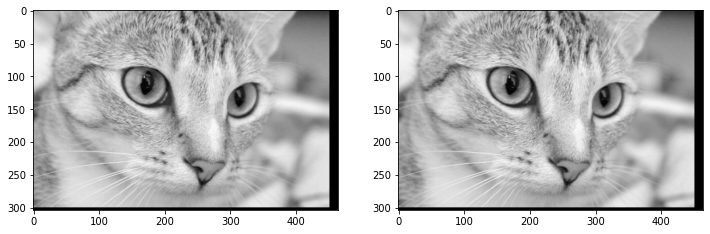

In [4]:
class Blocks:
    """Transforms an image to blocks. A (512, 512) image will become an (64, 64, 8, 8) numpy array"""
    def __init__(self, block_size=8):
        self.block_size = block_size
        
    def __call__(self, img):
        b = self.block_size
        height, width = img.shape

        assert img.shape[0] % b == 0
        assert img.shape[1] % b == 0
        blocks = np.zeros((height // b, width // b, b, b), dtype=img.dtype)
        for i in range(0, height // b):
            for j in range(0, width // b):
                blocks[i, j] = img[i*b:(i+1)*b, j*b:(j+1)*b]
        return blocks

    def invert(self, blocks):
        bh, bw = blocks.shape[:2]
        b = self.block_size
        heigth, width = (bh*self.block_size, bw*self.block_size)

        img = np.zeros((heigth, width), dtype=blocks.dtype)
        for i in range(0, bh):
            for j in range(0, bw):
                img[i*b:(i+1)*b, j*b:(j+1)*b] = blocks[i, j]
        return img

# test block operation on R-Channel
img_blocks = Blocks(block_size=8)(img[:, :, 0])
print(img_blocks.shape)
assert img_blocks.shape[2:] == (8, 8)
img_inv = Blocks(block_size=8).invert(img_blocks)

# the two images should be the same again after inverting
assert np.all(img[:, :, 0] == img_inv)

plt.subplot(121)
plt.imshow(img[:, :, 0], cmap='gray')
plt.subplot(122)
plt.imshow(img_inv, cmap='gray')
plt.show()

# Exercise 1 - Chroma Subsampling - 2 Points
Apply chroma subsampling to the image.

In [5]:
class ChromaSubsampling:
    """See https://en.wikipedia.org/wiki/YCbCr."""
    ycbcr = np.array([
        [0.299,  0.587,  0.114],
        [-0.168736, -0.331264,  0.5],
        [0.5, -0.418688, -0.081312],
    ])
    def __call__(self, rgb_img):
        """Transforms the rgb image to YCbCr. The cb and cr channels have half the resolution of the Y-channel.
           You can simply use the mean of four neighbours.
        """
        shape = rgb_img.shape
        
        #ycbcr_img = np.dot(self.ycbcr, rgb_img.reshape(-1, 3).T)
        #ycbcr_img = ycbcr_img.T.reshape(shape)
        #ycbcr_img[:,:, [1,2]] += 128
        # subsample the cb and cr channel, so that they have half the resolution of the Y-channel.
        # A simple thing might be to use the mean of 4 neighbours.
        derived_img = img.copy()
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                #y, pb, pr = np.matmul(self.ycbcr,img[i][j])
                y, cb, cr = np.matmul(self.ycbcr,img[i][j])
                derived_img[i][j] = y, 128+cb, 128+cr
        return derived_img[:, :, 0], derived_img[:, :, 1], derived_img[:, :, 2]
    
    def invert(self, inputs):
        y, cb, cr = inputs
        derived_img = np.zeros((y.shape[0],y.shape[1],3))
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                r = y[i][j]+1.402*(cr[i][j]-128)
                g = y[i][j]-0.344136*(cb[i][j]-128)-0.714136*(cr[i][j]-128)
                b = y[i][j]+1.772*(cb[i][j]-128)
                derived_img[i][j] = r,g,b
        return derived_img

Test the subsampling: The cr and cb channel should be half the resolution of the y channel.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


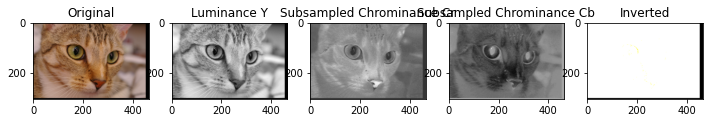

In [6]:
y, cb, cr = ChromaSubsampling()(img)
plt.subplot(151)
plt.title('Original')
plt.imshow(img)
plt.subplot(152)
plt.title('Luminance Y')
plt.imshow(y, cmap='gray')
plt.subplot(153)
plt.title('Subsampled Chrominance Cr')
plt.imshow(cr, cmap='gray')
plt.subplot(154)
plt.title('Subsampled Chrominance Cb')
plt.imshow(cb, cmap='gray')
plt.subplot(155)
plt.title('Inverted')
plt.imshow(ChromaSubsampling().invert((y,cb,cr)))
plt.show()

# Exercise 2 - DCT on 8x8 blocks - 2 Points
Apply DCT on 8x8 blocks. You may use np.fft` or `scipy.fftpack`.

In [7]:
class DCTofBlocks:
    def __call__(self, blocks):
        """Returns the DCT of the blocks. The position (i, j) is a 2-dim numpy array with the dct coefficients."""
        for i in range(blocks.shape[0]):
            for j in range(blocks.shape[1]):
                blocks[i][j] = scipy_dctn(blocks[i][j])
        return blocks

    def invert(self, blocks):
        """Computes the inverse DCT."""
        for i in range(blocks.shape[0]):
            for j in range(blocks.shape[1]):
                blocks[i][j] = scipy_idctn(blocks[i][j])
        return blocks

[[125 125 123 123 123 123 123 125]
 [128 127 125 124 124 124 124 124]
 [130 129 127 126 127 126 125 125]
 [134 132 130 130 128 127 127 127]
 [136 134 133 132 130 129 129 129]
 [138 136 135 135 134 132 130 129]
 [142 139 139 139 137 135 134 133]
 [145 142 142 141 139 137 137 136]]
[[232 109  60  38  50  16   0   0]
 [ 59 155  43 255 242 223 249 247]
 [102 221   0 251   0 255   2   3]
 [154 244 245 251   3 253   1 249]
 [ 39 250  25 233   4   7 255 252]
 [  0 251 246   0  10   0 255 251]
 [238 249 243   8   0 242   0   2]
 [  4 243   3 252 255 253   3   4]]
[[232 109  60  38  50  16   0   0]
 [ 59 155  43 255 242 223 249 247]
 [102 221   0 251   0 255   2   3]
 [154 244 245 251   3 253   1 249]
 [ 39 250  25 233   4   7 255 252]
 [  0 251 246   0  10   0 255 251]
 [238 249 243   8   0 242   0   2]
 [  4 243   3 252 255 253   3   4]]


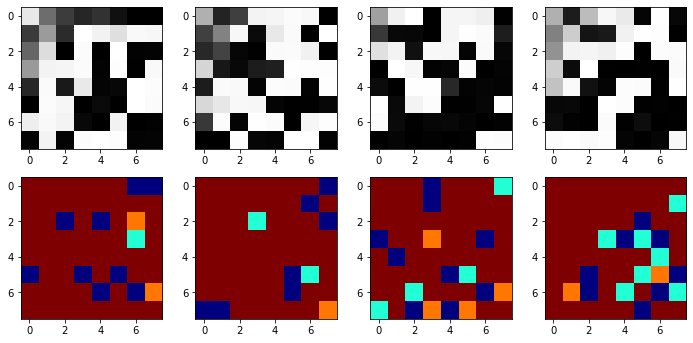

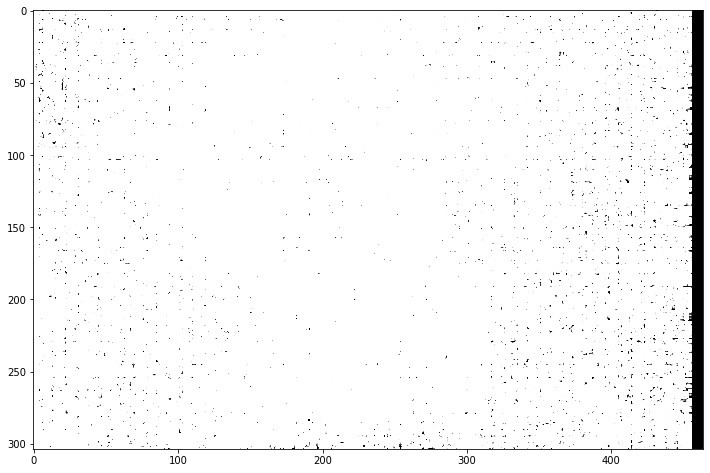

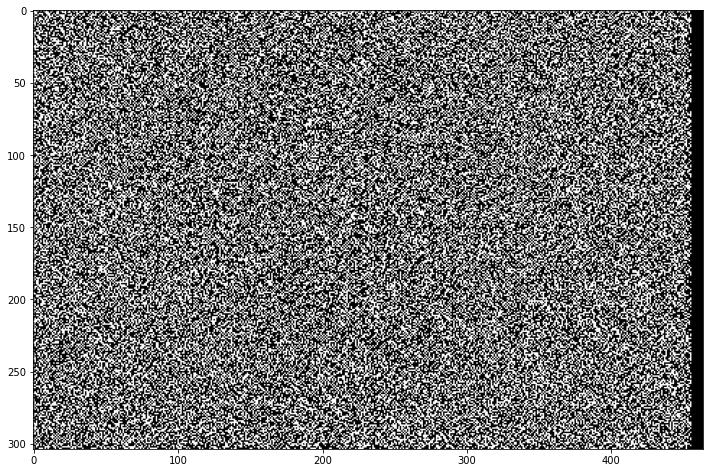

In [8]:
# print some blocks and their DCT on the y channel
y_block = Blocks()(y)
y_block_dct = DCTofBlocks()(y_block)

print(y[:8,:8])
print(y_block[0,0])
print(Blocks().invert(y_block)[:8,:8])
# shouldn't these 3 be equal? Why aren't they?! the Step y_block = Blocks()(y) doesn't seem to work properly for some reason...

plt.subplot(441)
plt.imshow(y_block[0, 0, :, :], cmap='gray')
plt.subplot(442)
plt.imshow(y_block[0, 1, :, :], cmap='gray')
plt.subplot(443)
plt.imshow(y_block[0, 2, :, :], cmap='gray')
plt.subplot(444)
plt.imshow(y_block[0, 3, :, :], cmap='gray')

plt.subplot(445)
plt.imshow(y_block_dct[0, 0, :, :], cmap='jet', vmax = np.max(y_block_dct[0, 0, :, :]) * 0.01,vmin = 0)
plt.subplot(446)
plt.imshow(y_block_dct[0, 1, :, :], cmap='jet', vmax = np.max(y_block_dct[0, 0, :, :]) * 0.01,vmin = 0)
plt.subplot(447)
plt.imshow(y_block_dct[0, 2, :, :], cmap='jet', vmax = np.max(y_block_dct[0, 0, :, :]) * 0.01,vmin = 0)
plt.subplot(448)
plt.imshow(y_block_dct[0, 3, :, :], cmap='jet', vmax = np.max(y_block_dct[0, 0, :, :]) * 0.01,vmin = 0)
plt.show()

# show full image
dct_img = Blocks().invert(y_block_dct)
plt.imshow(dct_img, cmap='gray', vmax = np.max(dct_img) * 0.01,vmin = 0)
plt.show()

# apply inverse DCT
plt.imshow(Blocks().invert(DCTofBlocks().invert(y_block_dct)), cmap='gray')
plt.show()


# Exercise 3 - Quantization - 2 Points
Apply quantization on the image with a threshold.

In [9]:
class Quantization:
    def __init__(self, threshold=1):
        # you can use the Q matrix from Wikipedia or invent your own.
        self.q_matrix = [[16, 11, 10, 16, 24, 40, 51, 61],[12, 12, 14, 19, 26, 58, 60, 55],[14, 13, 16, 24, 40, 57, 69, 56],[14, 17, 22, 29, 51, 87, 80, 62],[18, 22, 37, 56, 68, 109, 103, 77],[24, 35, 55, 64, 81, 104, 113, 92],[49, 64, 78, 87, 103, 121, 120, 101],[72, 92, 95, 98, 112, 100, 103, 99]]
        self.threshold = threshold

    def __call__(self, blocks):
        """Divides the blocks by the `q_matrix` elementwise. Coefficients below the `threshold` will be set to zero."""
        NewBlocks = blocks.copy()
        q_matrix = [[16, 11, 10, 16, 24, 40, 51, 61],[12, 12, 14, 19, 26, 58, 60, 55],[14, 13, 16, 24, 40, 57, 69, 56],[14, 17, 22, 29, 51, 87, 80, 62],[18, 22, 37, 56, 68, 109, 103, 77],[24, 35, 55, 64, 81, 104, 113, 92],[49, 64, 78, 87, 103, 121, 120, 101],[72, 92, 95, 98, 112, 100, 103, 99]]
        for i in range(blocks.shape[0]):
            for j in range(blocks.shape[1]):
                NewBlocks[i][j] = np.divide(blocks[i][j],q_matrix)
                for x in range(NewBlocks.shape[2]):
                    for y in range(NewBlocks.shape[3]):
                        if NewBlocks[i][j][x][y] < self.threshold:
                            NewBlocks[i][j][x][y] = 0
        return NewBlocks

    def invert(self, blocks):
        """ For inverting multiply your elements piecewise with the Q-Matrix"""
        NewBlocks = blocks.copy()
        q_matrix = [[16, 11, 10, 16, 24, 40, 51, 61],[12, 12, 14, 19, 26, 58, 60, 55],[14, 13, 16, 24, 40, 57, 69, 56],[14, 17, 22, 29, 51, 87, 80, 62],[18, 22, 37, 56, 68, 109, 103, 77],[24, 35, 55, 64, 81, 104, 113, 92],[49, 64, 78, 87, 103, 121, 120, 101],[72, 92, 95, 98, 112, 100, 103, 99]]
        for i in range(blocks.shape[0]):
            for j in range(blocks.shape[1]):
                NewBlocks[i][j] = np.matmul(blocks[i][j],q_matrix)
        return NewBlocks

Try different quantizations. You should see that with increasing threshold the image becomes more blurry compared to the original.

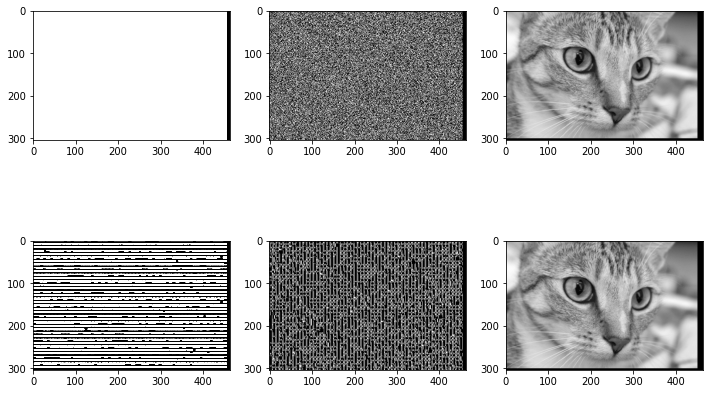

In [10]:
quant_1 = Quantization(threshold=2)(y_block_dct)
quant_img_1 = Blocks().invert(Quantization().invert(quant_1))
quant_2 = Quantization(threshold=20)(y_block_dct)
quant_img_2 = Blocks().invert(Quantization().invert(quant_2))
plt.subplot(331)
plt.imshow(quant_img_1, cmap='gray', vmax = np.max(quant_img_1) * 0.01,vmin = 0)
plt.subplot(332)
plt.imshow(Blocks().invert(DCTofBlocks().invert(Quantization().invert(quant_1))), cmap='gray')
plt.subplot(333)
plt.imshow(y, cmap='gray')
plt.subplot(334)
plt.imshow(quant_img_2, cmap='gray', vmax = np.max(quant_img_2) * 0.01,vmin = 0)
plt.subplot(335)
plt.imshow(Blocks().invert(DCTofBlocks().invert(Quantization().invert(quant_2))), cmap='gray')
plt.subplot(336)
plt.imshow(y, cmap='gray')
plt.show()

# Exercise 4 - Pick n-th highest (highest amplitudes of frequencies) - 2 Points
Implement the pick n-th highest algorithm

In [11]:
def zigzag(n):
    y = lx = 0
    x = ly = 1
    if n == 1:
        return [0,0]
    if n == 2:
        return [0,1]
    if n == 3:
        return [1,0]
    for i in range(n-3):
        if x-lx == 0:
            lx = x
            ly = y
            x = 1
            y -= 1
        elif y-ly == 0:
            lx = x
            ly = y
            x -= 1
            y = 1
        elif x>lx:
            lx = x
            ly = y
            x += 1
            y -= 1
        else:
            lx = x
            ly = y
            x -= 1
            y += 1
        if x < 0:
            x = 0
        if y < 0:
            y = 0
    return x,y

class PickNthHighest:
    def __init__(self, n=1):
        self.n = n

    def __call__(self, blocks):
        """Pick the nth-highest frequencies"""
        height,width,blockheight,blockwidth = blocks.shape
        x,y = zigzag(self.n)
        block_mask = np.zeros((blockheight,blockwidth))
        for i in range(height):
            for j in range(width):
                block_mask[x,y] = blocks[i,j,x,y]
                blocks[i,j] = block_mask
        return blocks

    def invert(self, blocks):
        """There is no way to invert this operation. Just return the inputs."""
        return blocks

Try out pick n-th highest compression.

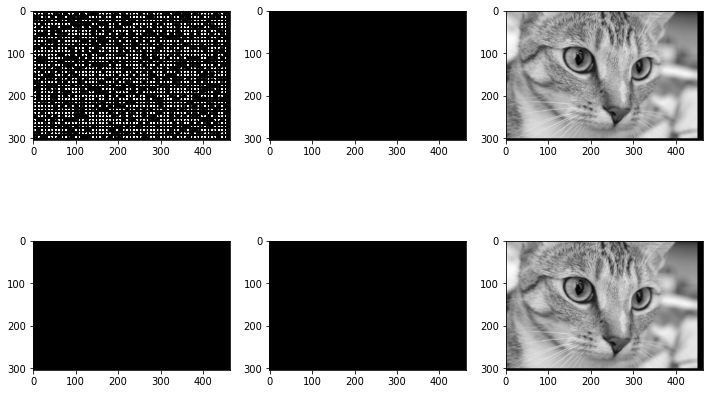

In [12]:
pick_1 = PickNthHighest(n=16)(y_block_dct)
pick_img_1 = Blocks().invert(pick_1)
pick_2 = PickNthHighest(n=8)(y_block_dct)
pick_img_2 = Blocks().invert(pick_2)
plt.subplot(331)
plt.imshow(pick_img_1, cmap='gray', vmax = np.max(pick_img_1) * 0.01,vmin = 0)
plt.subplot(332)
plt.imshow(Blocks().invert(DCTofBlocks().invert(pick_1)), cmap='gray')
plt.subplot(333)
plt.imshow(y, cmap='gray')
plt.subplot(334)
plt.imshow(pick_img_2, cmap='gray', vmax = np.max(pick_img_2) * 0.01,vmin = 0)
plt.subplot(335)
plt.imshow(Blocks().invert(DCTofBlocks().invert(pick_2)), cmap='gray')
plt.subplot(336)
plt.imshow(y, cmap='gray')
plt.show()



# Entropy encoding
This class applies the zigzag algorithm to compress the matrix

In [13]:
class ZigZag:
    def __init__(self, n):
        self.n = n
        """Adapted from here: https://rosettacode.org/wiki/Zig-zag_matrix#Python"""
        def key(pair):
            x, y = pair
            return x+y, -y if (x+y) % 2 else y

        n = 8
        indexorder = sorted(((x,y) for x in range(n) for y in range(n)), key=key)
        self.xs = np.zeros((self.n**2,), dtype=int)
        self.ys = np.zeros((self.n**2,), dtype=int)
        self.back = np.zeros((n, n), dtype=int)
        for i, (x, y) in enumerate(indexorder):
            self.xs[i] = x
            self.ys[i] = y
            self.back[x, y] = i
            
    def __call__(self, blocks):
        bh, bw, h, w = blocks.shape
        zigzack_blocks = np.zeros((bh, bw, h*w), dtype=blocks.dtype)
        for i, block_row in enumerate(blocks):
            for j, block in enumerate(block_row):
                zigzack_blocks[i, j] = block[self.xs, self.ys] 
        return zigzack_blocks
    
    def invert(self, zigzack_blocks):
        bh, bw, hw = zigzack_blocks.shape
        h = int(np.sqrt(hw))
        blocks = np.zeros((bh, bw, h, h), dtype=zigzack_blocks.dtype)
        for i, zigzack_row in enumerate(zigzack_blocks):
            for j, zigzack in enumerate(zigzack_row):
                blocks[i, j] = zigzack[self.back] 
        return blocks

zigzag = ZigZag(8)
range_mat = np.arange(64).reshape((1, 1, 8, 8))
zigzack_mat = zigzag(range_mat)
assert np.all(zigzag.invert(zigzack_mat) == range_mat)

print(range_mat)
print(zigzack_mat)

[[[[ 0  1  2  3  4  5  6  7]
   [ 8  9 10 11 12 13 14 15]
   [16 17 18 19 20 21 22 23]
   [24 25 26 27 28 29 30 31]
   [32 33 34 35 36 37 38 39]
   [40 41 42 43 44 45 46 47]
   [48 49 50 51 52 53 54 55]
   [56 57 58 59 60 61 62 63]]]]
[[[ 0  1  8 16  9  2  3 10 17 24 32 25 18 11  4  5 12 19 26 33 40 48 41
   34 27 20 13  6  7 14 21 28 35 42 49 56 57 50 43 36 29 22 15 23 30 37
   44 51 58 59 52 45 38 31 39 46 53 60 61 54 47 55 62 63]]]


In [14]:
class Compress:
    """This class compresses arbitrary input using the bz2 algorithm"""
    def __init__(self, dtype=np.uint8):
        self.dtype = dtype
        self.max_value = (np.iinfo(dtype).max / 1.1)
        
    def __call__(self, arr):
        # print("dtype: {}".format(arr.dtype))
        # print("max: {}, min: {}".format(arr.max(), arr.min()))
        scale = max(abs(arr.max()), abs(arr.min()))
        arr = arr / scale
        arr = arr * self.max_value
        arr = np.rint(arr)
        arr = arr.astype(self.dtype)
        bytearr = arr.data.tobytes()
        
        return zipfile.bz2.compress(bytearr), arr.shape, arr.dtype, scale
    
    def invert(self, inputs):
        bytearr, shape, dtype, scale = inputs
        decom_bytes = zipfile.bz2.decompress(bytearr)
        arr = np.frombuffer(decom_bytes, dtype=self.dtype)
        arr = arr.astype(dtype)
        arr = arr / self.max_value * scale
        return arr.reshape(shape)

range_mat = np.arange(64, dtype=np.float64).reshape((1, 1, 8, 8))
compress = Compress()
compressed = compress(range_mat)
# print((compress.invert(compressed)))
assert np.allclose(compress.invert(compressed), range_mat, 0.5, 0.5)

In [15]:
class Jpeg:
    def __init__(self, stages):
        self.stages = stages
    
    def __call__(self, img):
        y, cb, cr = ChromaSubsampling()(img)
        outputs = []
        for input in [y, cb, cr]:
            output = input
            for stage in self.stages:
                input = output
                try:
                    output = stage(input)
                except:
                    print("Error in Stage: {}".format(type(stage).__name__))
                    raise
            outputs.append(output)
        return outputs
    
    def invert(self, inputs):
        outputs = []
        for output in inputs:
            for stage in self.stages[::-1]:
                input = output
                try:
                    output = stage.invert(input)
                except:
                    print("Error in Stage: {}".format(type(stage).__name__))
                    raise
            outputs.append(output)
        y, cb, cr = outputs
        return ChromaSubsampling().invert([y, cb, cr])
    


In [16]:
def total_size_jpeg(jpeg_output):
    """Sums the number of bytes over the different compression channels: y, cb, cr"""
    nb_bytes = sum([len(x[0]) for x in jpeg_output])
    return "{:.1f}KB".format(nb_bytes / 1000)

def total_size_numpy(arr):
    return "{:.1f}KB".format(len(arr.data.tobytes()) / 1000)

def naive_compression_size(arr):
    bytearr = arr.data.tobytes()
    nb_bytes = len(zipfile.bz2.compress(bytearr))
    return "{:.1f}KB".format(nb_bytes / 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


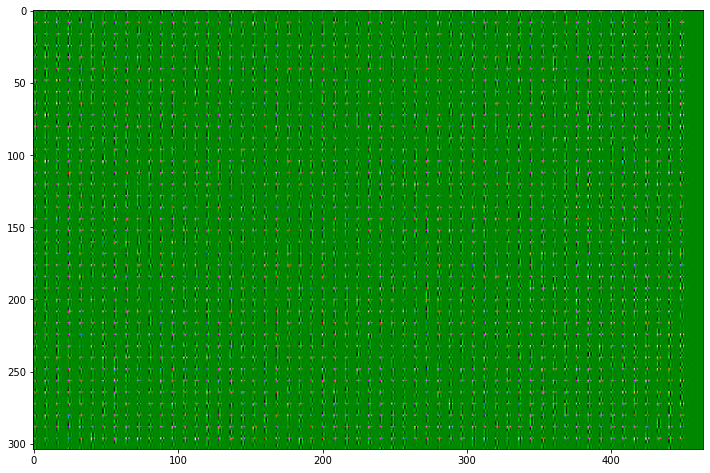

In [17]:
# build the jpeg pipeline
# for testing you can use only the first ones.
# maybe you have to adjust the Quantization threshold settings.
jpeg = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=10), ZigZag(8), Compress(np.uint8)])

img_jpeg = jpeg(img)
img_reconstruct = jpeg.invert(img_jpeg)
# assert img_reconstruct.shape == img.shape
# once you implemented ChromaSubsampling.invert this should have colors :)
plt.imshow(img_reconstruct / 255)
plt.show()

In [18]:
chromasubsampling_compression = Jpeg([Blocks(8), Compress()])
print("No compression: " + total_size_numpy(img))
print("Direct compression of the image: " + naive_compression_size(img))
print("Croma subsampling and compression: " + total_size_jpeg(chromasubsampling_compression(img)))

No compression: 423.2KB
Direct compression of the image: 250.5KB
Croma subsampling and compression: 176.8KB


# Exercise 5 - Pipeline comparison - 2 Points
Compare different pipeline setups and complete the tasks below.

In [19]:
# Compare the size of the images if the zigzag encoding is removed.
# Does the size change if the quantization threshold increases?
jpeg0 = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=5), Compress(np.uint8)])
jpeg1 = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=10), Compress(np.uint8)])
jpeg2 = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=15), Compress(np.uint8)])
jpeg3 = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=20), Compress(np.uint8)])
jpeg01 = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=5), ZigZag(8), Compress(np.uint8)])
jpeg11 = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=10), ZigZag(8), Compress(np.uint8)])
jpeg21 = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=15), ZigZag(8), Compress(np.uint8)])
jpeg31 = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=20), ZigZag(8), Compress(np.uint8)])

print(total_size_jpeg(jpeg0(img)))
print(total_size_jpeg(jpeg1(img)))
print(total_size_jpeg(jpeg2(img)))
print(total_size_jpeg(jpeg3(img)))
print(total_size_jpeg(jpeg01(img)))
print(total_size_jpeg(jpeg11(img)))
print(total_size_jpeg(jpeg21(img)))
print(total_size_jpeg(jpeg31(img)))

# Increasing the threshold can decrease the size of the image a lot, depending on the thresholds chosen. The zigzag encoding decreases the image size slightly for lower thresholds
# while slightly increasing it for higher ones.

74.8KB
44.7KB
19.0KB
4.6KB
71.2KB
43.9KB
19.3KB
4.6KB


In [20]:
# Compare the image quality of the `Quantization` vs. the `PickNthHighest` compressions. Therefore use a metric, the root
# mean square of pixel differences. Make sure that the outputs are roughly the same size. Why is one better than the other one?

# your code here

# your short answer here